In [1]:
import scipy.io as sio
import numpy as np
from scipy.optimize import minimize, least_squares, lsq_linear, nnls
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

#! pip install cvxopt
from cvxopt import matrix, solvers

%matplotlib inline

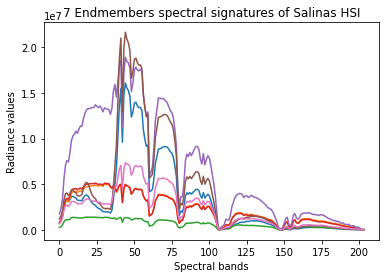

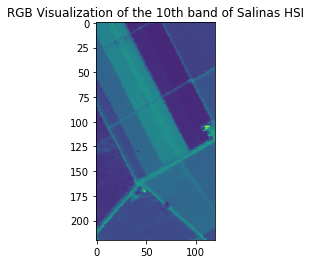

In [2]:
Salinas = sio.loadmat('Salinas_cube.mat')
HSI = Salinas['salinas_cube'] #Salinas HSI : 220x120x204

ends = sio.loadmat('Salinas_endmembers.mat') # Endmember's matrix: 204x7
endmembers = ends['salinas_endmembers']
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('7 Endmembers spectral signatures of Salinas HSI')
plt.show()

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('Salinas_gt.mat')
labels=ground_truth['salinas_gt']

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Salinas HSI')
plt.show()
# For the non-negative least squares  unmixing algorithm  you can use the nnls function, see the following link:
#https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.nnls.html#scipy.optimize.nnls
# ..............
#
#..................

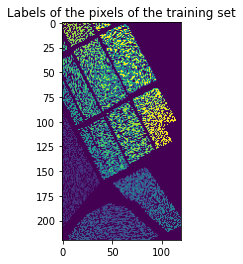

In [3]:
# Trainining set for classification 
Salinas_labels = sio.loadmat('classification_labels_Salinas.mat')
Training_Set = (np.reshape(Salinas_labels['training_set'],(120,220))).T
Test_Set = (np.reshape(Salinas_labels['test_set'],(120,220))).T
Operational_Set = (np.reshape(Salinas_labels['operational_set'],(120,220))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

In [4]:
Salinas

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Mar  1 14:46:31 2021',
 '__version__': '1.0',
 '__globals__': [],
 'salinas_cube': array([[[369, 579, 866, ...,  31,   9,  15],
         [369, 495, 735, ...,  33,  13,  15],
         [369, 495, 866, ...,  33,  11,  19],
         ...,
         [373, 398, 725, ...,  12,   4,   2],
         [373, 398, 659, ...,   8,   4,   0],
         [373, 482, 594, ...,   8,   0,   5]],
 
        [[441, 558, 787, ...,  26,  11,  16],
         [441, 558, 787, ...,  32,   7,  12],
         [441, 474, 787, ...,  26,   9,  16],
         ...,
         [447, 393, 590, ...,   3,   0,   9],
         [376, 393, 655, ...,  11,   0,   6],
         [376, 393, 590, ...,   3,   5,  -3]],
 
        [[444, 566, 790, ...,  30,  10,  15],
         [373, 566, 790, ...,  30,  12,  21],
         [373, 398, 790, ...,  32,  16,  13],
         ...,
         [305, 468, 534, ...,   6,   3,  -1],
         [376, 384, 664, ...,   6,   1,  -3],
         [376, 

In [5]:
X = endmembers
X

array([[ 859449,  760400,  269779, ..., 1766174, 1236288,  693400],
       [1085519,  987850,  346869, ..., 2314448, 1540378,  901617],
       [1537041, 1438887,  522332, ..., 3313375, 2057140, 1282030],
       ...,
       [  10865,   95408,   23453, ...,  125586,   16963,   34600],
       [   4222,   33340,    8098, ...,   43662,    6328,   11967],
       [   6201,   52982,   12739, ...,   69644,    9434,   19435]])

First, we see the size of our data, and keep variables of each dimension in order to do more easily our job.

In [6]:
print(f"The size of HSI: {HSI.shape}.")
print(f"The size of endmembers: {X.shape}.")

The size of HSI: (220, 120, 204).
The size of endmembers: (204, 7).


In [7]:
M = HSI.shape[0]  # first dimension
N = HSI.shape[1]  # second dimension
L = HSI.shape[2]  # third dimension

E = X.shape[1] # the number of endmembers

print(f"The pixels are {M}x{N} and the labels are {L}.")
print(f"The number of variables of our model is {E}.")

The pixels are 220x120 and the labels are 204.
The number of variables of our model is 7.


## Part 1

In [22]:
def rec_err(y_pred):
    """The function for computing the reconstruction error of the methods.
    Inputs: y_pred: The vector with the predicted labels, y_pred = Xθ_i.
    Outputs: mean_error: The average error ||y - Xθ_i||^2. """
    
    errors = np.zeros((len(labels[labels>0]))) # create an array with zeros and length the number of labels > 0
    k = 0 # the index of the error array
    for i in range(M): 
        for j in range(N):
            if labels[i][j] != 0: # we calculate the error only for labels greater than zero, because only these labels we have used
                errors[k] = np.linalg.norm(HSI[i,j] - y_pred[i,j])**2  # calculate the error ||y - Xθ_i||^2.
                k += 1
    mean_error = np.mean(errors)
    return mean_error

In [23]:
def abundance_maps(theta):
    """The function that prints the abundance maps.
    Inputs: theta: The vector with thetas of our model.
    Outputs: fig: The figure with the 7 plots of abundance maps"""
    fig = plt.figure(figsize=(20, 20))
    for i in range(7):
        plt.subplot(1,7,i+1) # create the subplot
        theta_i = theta[:,:,i]
        plt.imshow(theta_i) # plot the image
        title = ('Endmember :'+ str(i+1))
        plt.title(title, size=12)
        plt.xticks(()) # dont show any ticks
        plt.yticks(()) # dont show any ticks
    plt.close()
    return fig

### a. 
Least squares method

Firstly we fit a simple model with the method of least squares. We fit our model for each pixels, with labels greater than zero, finding the predicted 204 labels for each pixel.

In [24]:
theta_ls = np.zeros((M,N,E)) # create an array with zeros and shape (220,120,7) for the predicted thetas of the models
y_pred_ls = np.zeros((M,N,L)) # create an array with shape (220,120,204) for the predicted labels
for i in range(M):
    for j in range(N):
        if labels[i,j] != 0: # do the calculations only for pixels with labels >0.
            y = HSI[i,j]
            XTX_inv = np.linalg.inv(np.dot(X.T,X))
            theta = (XTX_inv).dot(X.T).dot(y.T)
            theta_ls[i,j] = theta
            yp = X.dot(theta.T).transpose() # calculate the predicted labels
            y_pred_ls[i,j] = yp
            
            
print(f"The reconstruction error for the least squares is: {round(rec_err(y_pred_ls),2)}.")

The reconstruction error for the least squares is: 1.7736299590314877e+21.


The abundance maps for the least squares method are the following:


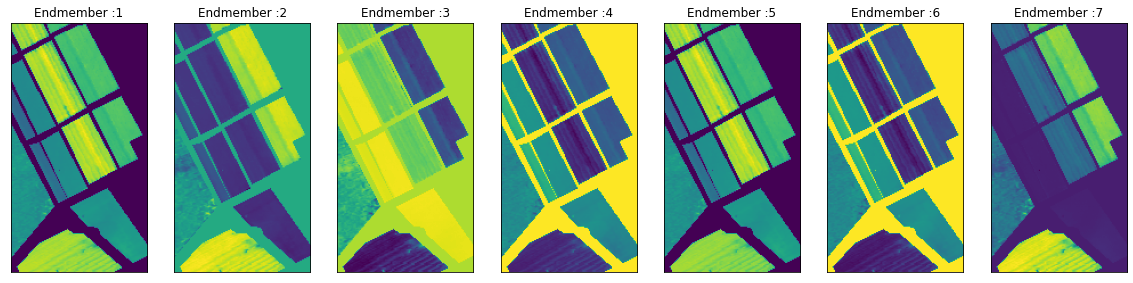

In [25]:
print("The abundance maps for the least squares method are the following:")
abundance_maps(theta_ls) # print the abundance maps using the method we have created.

### b.
Least squares method with sum to one constraint

Now we will fit the least squares method with the constraint all the thetas of each pixel be summed to one. First we define the objective function to be minimized which is $||Ax - b||_2$. Then we will define the constraints which is $\sum_{i=1}^{7}θ_{i} = 1$ for each pixel. Finally, we will use the function minimize from the library scipy.optimize in order to minimize the objective function with the sum to one constraint, with least squares method.

In [26]:
def objective_fun(x, A, b):
    """The objective function for our models.
    Inputs: x: The vector that is the variable of the function.
            A: The matrix of the coefficients
            b: The vector of ocnstant coefficients
    Outputs: The norm ||A*x - b||"""
    
    return np.linalg.norm(np.dot(A,x) - b)

In [27]:
# The constraint of Σx = 1 (sum to one)
constr = ({'type': 'eq', 'fun': lambda x:  np.sum(x)-1})

In [ ]:
theta_sum_to_one = np.zeros((M,N,E)) # all the thetas for each pixel  
y_pred_sum_tο_one = np.zeros((M,N,L)) # all the predictions for each pixel
x_nnls = nnls(X, y)[0]

for i in range(M):
    for j in range(N):
        if labels[i,j]!=0: # consider only the pixel with known label
            y = HSI[i,j,:] 
            x_nnls = nnls(X, y)[0] # non negative least squares to provide a natural starting point
            minim = minimize(objective_fun, x0=x_nnls, args = (X,y), method = 'SLSQP', constraints = constr) # minimize function
            theta = minim.x # take the estimations of theta
            theta_sum_to_one[i,j] = theta
            yp =  np.dot(X,theta)
            y_pred_sum_tο_one[i,j] = yp

In [ ]:
print("The abundance maps for the least squares with sum to one constraint method are the following:")
abundance_maps(theta_sum_to_one)

In [ ]:
print(f"The reconstruction error for the least squares with sum to one constraint is: \
{round(rec_err(y_pred_sum_tο_one),2)}.")

### c.
Least squares method with non-negativity constraint

Next, we want to estimate the parameters theta with least sqaures method but with a non-negativity constraint. That means that each theta of each vector will be positive or zero. We will use the lsq_linear method from the library scipy_optimize, and as bounds we will use (0,None). 

In [ ]:
theta_nonnegative = np.zeros((M,N,E)) # all thetas for each pixel
y_pred_nonnegative = np.zeros((M,N,L)) # all predictions for each pixel

for i in range(M):
    for j in range(N):
        if labels[i][j] != 0: # only for labels greater than 0
            y = HSI[i,j,:]
            minim = lsq_linear(X,y, bounds = (0,None), method="bvls") # linear least squares with non negativity contraint
            theta = minim.x # take the estimations of thetas
            theta_nonnegative[i,j] = theta
            yp =  np.dot(X,theta)
            y_pred_nonnegative[i,j] = yp

In [ ]:
print("The abundance maps for the least squares with non-negativity contraint method are the following:")
abundance_maps(theta_nonnegative)

In [ ]:
print(f"The reconstruction error for the least squares with the non negatvity contraint is: \
{round(rec_err(y_pred_nonnegative),2)}.")

### d.
Least squares method with sum to one and non-negativity constraint.

Now we will combine the two previous constraints into one method. For this purpose we will use the solvers.qp() function from the cvxopt library. In order to do this we first need to transform our problem into a quadratic problem. We find a pretty good solution of this problem in this link: https://scaron.info/blog/quadratic-programming-in-python.html?fbclid=IwAR38y81Uv9bNnCtXf3UPkfuWLe6XOfZn8B_lp9KM__wf3VX7fbYoCPzXIx4. 

In [ ]:
theta_all_constr = np.zeros((M,N,E,1)) # all thetas for each pixel
y_pred_all_constr = np.zeros((M,N,L,1)) # all predictions for each pixel
X_d = np.double(X)
for i in range(M):
    for j in range(N):
        if labels[i,j] != 0:
            y = np.double(HSI[i,j,:])
            P = matrix(2*np.dot(X_d.T,X_d),(7,7),'d')
            q = matrix(-np.dot(X_d.T,y),(7,1),'d')
            G = matrix(-np.identity(7), (7,7), 'd')
            h = matrix([0, 0, 0, 0, 0, 0, 0],(7,1),'d')
            A = matrix([1,1,1,1,1,1,1], (1,7), 'd')
            b = matrix(1.0)
            sol = solvers.qp(P,q,G,h,A,b, options={'show_progress': False})
            theta = np.array(sol['x'])
            theta_all_constr[i,j,:] = theta
            yp =  np.dot(X,theta)
            y_pred_all_constr[i,j] = yp

In [ ]:
print("The abundance maps for the least squares with sum to one and non-negativity constraints method are the following:")
abundance_maps(theta_all_constr)

In [ ]:
print(f"The reconstruction error for the least squares with sum to one and non-negativity constraints is: \
{round(rec_err(y_pred_all_constr),2)}.")

### e.
Lasso method

Finally, we fit the lasso model, which is a least squares method that penatlises on thetas and provide sparse solutions. The objective function for lasso is $L(θ) = \sum_{i=1}^{N}(y_n - \mathbf{θ^{Τ}x_n})^2 + λ||θ||_1$. We can use the ready built in function Lasso from the sklearn library.

In [ ]:
theta_lasso = np.zeros((M,N,E))
y_pred_lasso = np.zeros((M,N,L))
for i in range(M):
    for j in range(N):
        if labels[i,j]!=0:
            y = HSI[i,j,:]
            # fit the lasso with λ = 0.1, with positive coefficients, without intercept and use the same random state each time we run it
            fit_lasso = Lasso(alpha=1, max_iter=10**7, positive=True, fit_intercept=False, random_state=40).fit(X,y)
            # keep the coefficients of the model
            theta = fit_lasso.coef_
            theta_lasso[i,j] = theta
            # predict the labels
            yp =  np.dot(X,theta)
            y_pred_lasso[i,j] = yp

In [ ]:
print("The abundance maps for the lasso method are the following:")
abundance_maps(theta_lasso)

In [ ]:
print(f"The reconstruction error for the lasso least squares is: {round(rec_err(y_pred_lasso),2)}.")

Below we print the image with the truth labels of pixels. This figure will help us to compare our models with the truth.

In [ ]:
fig = plt.figure(figsize = (5,5))
plt.imshow(labels)
plt.title('True labels of the pixels', fontsize = "15")
plt.colorbar()
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
# keep a dictionary with all predictions
methods_y = {'least squares': y_pred_ls,
           'sum to one': y_pred_sum_tο_one,
           'non negativity': y_pred_nonnegative,
           'sum to one nonnegative': y_pred_all_constr,
           'lasso': y_pred_lasso}

for meth in methods_y:
    print(f"The reconstruction error for the {meth} method is: {rec_err(methods_y[meth]):.4e}.")

We see that the smallest reconstruction error resulting from the non negativity least squares method. So we  can conclude that the sum to one constraint does not add any further information in order to improve our model. The lasso method has also a very similar error. So, these three methods seem to fit better the model. 


Also, from the abundance maps we see that two three methods approximate very good the labels of the maps and are very colse to each other, while the others does not seem so good.

#### Important note
The first endmember is the darkest color and the last endmember the brigtest. In our abundance maps each endmember provides a bright color in the respective place, and a dark color every where else. Thus, each endmember of the plotted abundance maps must match with the respective color in colorbar. Although the abundance maps for the last three methods seem very well, and very close to the original, we observe that the endmember 1, shows the label 2, the endmember the label 3 and so on, till the endmember 7 that shows the label 1. Maybe we have a shift in our dataset and the labels does not match the colors as in figure above.

## Part 2

Next we proceed to the second part where we will try to classify the labels using the Naive Bayes method, the minimum Euclean distance method, the k-nearest neighbors method and the Bayesian method.

In [120]:
X_train = []
y_train = []

for i in range(M):
    for j in range(N):
        if Training_Set[i,j] != 0: # keep only the non zero labels
            X_train.append(HSI[i,j,:]) # training X from HSI
            y_train.append(Training_Set[i,j]) # training labels

X_train = np.array(X_train)
y_train = np.array(y_train)

In [121]:
X_test = []
y_test = []

for i in range(M):
    for j in range(N):
        if Test_Set[i,j] != 0: # keep only the non zero labels
            X_test.append(HSI[i,j,:]) # testing X from HSI
            y_test.append(Test_Set[i,j]) # testing labels
X_test = np.array(X_test)
y_test = np.array(y_test)

In [122]:
X_oper = []
y_oper = []

for i in range(M):
    for j in range(N):
        if Operational_Set[i,j] != 0: # keep only the non zero labels
            X_oper.append(HSI[i,j,:]) # operational X from HSI
            y_oper.append(Operational_Set[i,j]) # operational labels

X_oper = np.array(X_oper)
y_oper = np.array(y_oper)

In [123]:
lab = list(np.unique(labels))[1:] # take the unique labels [1,2,3,4,5,6,7] for the ticks in plots

### i) 
Naive Bayes Classifier

For this classifier we will use the gaussian naive bayes from the sklearn library.

In [124]:
naive_model = GaussianNB()

Run 10-fold cross validation score for the naive bayes classifier and obtain the 10 errors.

In [125]:
naive_scores = cross_val_score(naive_model, X_train, y_train, cv=10, scoring='accuracy')
mean_error = np.mean(1 - naive_scores)
std_error = np.std(1 - naive_scores)
print(f"The mean validation error for Naive Bayes is {mean_error:.4f}.")
print(f"The standard deviation of the mean validation error for Naive Bayes is {std_error:.4f}.")

The mean validation error for Naive Bayes is 0.0262.
The standard deviation of the mean validation error for Naive Bayes is 0.0160.


In [126]:
naive_model.fit(X_train, y_train.flatten()) # fit the naive bayes model
y_pred_naive = naive_model.predict(X_test) # get the predictions

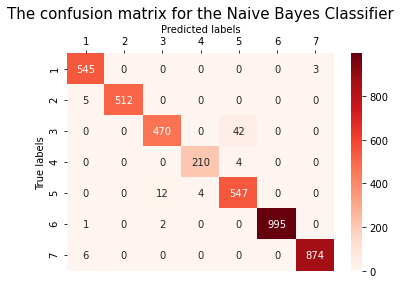

In [127]:
confusion_naive = confusion_matrix(y_test, y_pred_naive) # get the confusion matrix

fig, ax = plt.subplots()
ax = sns.heatmap(confusion_naive, annot=True, fmt='g', xticklabels=lab, yticklabels=lab, cmap="Reds")
ax.set_title("The confusion matrix for the Naive Bayes Classifier", fontsize = 15)
ax.set_xlabel('Predicted labels')
ax.set_ylabel("True labels")
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.show()

In [128]:
accuracy_naive = accuracy_score(y_test,y_pred_naive)
print(f"The accuracy of the Naive Bayes Classifier is: {accuracy_naive:.4f}.")
# confusion_naive.diagonal().sum() / confusion_naive.sum()

The accuracy of the Naive Bayes Classifier is: 0.9813.


### ii)
Minimum Euclean distance Classifier

We will implement this classifier without the help of built-in functions. First we will define a function that computes the mean for each class. 

In [129]:
def means(X, y):
    """function to compute the sample means for each pixel
    Inputs: X matrix
    Outputs: y vector"""
    m = np.zeros((7,L))
    for i in range(1,8):
        m[i-1] = np.mean(X[y==i], axis=0) # get the mean for each distinct class
    
    return m

Then, we define a function that provides the predictions for each pixel.

In [130]:
def predictions(X, m):
    """function to calculate the predictions
    Inputs: X matrix
    Outputs: m  vector of means"""
    dist = np.empty((7,X.shape[0]))
    
    for i in range(X.shape[0]): #iterate through the pixels
        for j in range(7): # iterate through the classes
            dist[j,i] = np.linalg.norm(X[i] - m[j]) # compute the distance oF X from each mean
    
    #dist = np.array(dist)
    pred = np.argmin(dist, axis=0) + 1 # plus one because the indexing in python starts from 0, but we want the classes from 1
    
    return pred

Run 10-fold cross validation and obtain the mean and the standard deviation of the errors. We implement the cross validation without any library, because the classifier we use does not use any library.

In [131]:
folds = KFold(n_splits=10, shuffle=True) #get 10 random folds 
splits = folds.split(X_train, y_train) # get the training and testing sets for the cross validation
mindist_scores = []

for i, j in splits:
    m_fold = means(X_train[i], y_train[i]) # get the mean 
    pred_fold = predictions(X_train[j], m_fold) # get the predicitons for the validation set
    mindist_scores.append((pred_fold == y_train[j]).sum() / len(pred_fold)) # calculate the accuracy
    
mindist_scores = np.array(mindist_scores)

mean_error = np.mean(1 - mindist_scores)
std_error = np.std(1 - mindist_scores)
print(f"The mean validation error for Minimum Euclean Distance is {mean_error:.4f}.")
print(f"The standard deviation of the mean validation error for Minimum Euclean Distance is {std_error:.4f}.")

The mean validation error for Minimum Euclean Distance is 0.0442.
The standard deviation of the mean validation error for Minimum Euclean Distance is 0.0086.


Run the minimum distance classifier and get the predictions for each pixel with the help of the above functions.

In [132]:
m = means(X_train, y_train) # get the means for the classes
y_pred_mindist = predictions(X_test, m) # get the predictions 

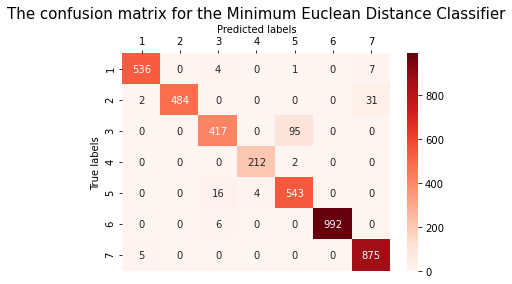

In [133]:
confusion_mindist = confusion_matrix(y_test, y_pred_mindist) # get the confusion matrix

fig, ax = plt.subplots()
ax = sns.heatmap(confusion_mindist, annot=True, fmt='g', xticklabels= lab, yticklabels=lab, cmap='Reds')
ax.set_title("The confusion matrix for the Minimum Euclean Distance Classifier", fontsize = 15)
ax.set_xlabel('Predicted labels')
ax.set_ylabel("True labels")
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.show()

In [134]:
accuracy_mindist = accuracy_score(y_test,y_pred_mindist)# get the accuracy 
print(f"The accuracy of the Minimum Euclean Distance Classifier is: {accuracy_mindist:.4f}.")
# confusion_mindist.diagonal().sum() / confusion_mindist.sum()

The accuracy of the Minimum Euclean Distance Classifier is: 0.9591.


### iii)
k-Nearest Neighbors Classifier

In [135]:
knn_model = KNeighborsClassifier(n_neighbors=10)

In [136]:
knn_scores = cross_val_score(knn_model, X_train, y_train, cv=10, scoring='accuracy')
mean_error = np.mean(1 - knn_scores)
std_error = np.std(1 - knn_scores)
print(f"The mean validation error for KNN is {mean_error:.4f}.")
print(f"The standard deviation of the mean validation error for KNN is {std_error:.4f}.")

The mean validation error for KNN is 0.0123.
The standard deviation of the mean validation error for KNN is 0.0144.


In [137]:
knn_model.fit(X_train, y_train.flatten())
y_pred_knn = knn_model.predict(X_test)

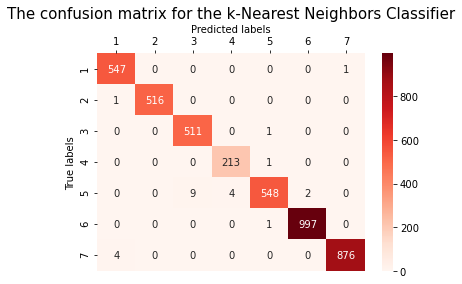

In [138]:
confusion_knn = confusion_matrix(y_test, y_pred_knn) # get the confusion matrix

fig, ax = plt.subplots()
ax = sns.heatmap(confusion_knn, annot=True, fmt='g', xticklabels=lab, yticklabels=lab, cmap="Reds")
ax.set_title("The confusion matrix for the k-Nearest Neighbors Classifier", fontsize = 15)
ax.set_xlabel('Predicted labels')
ax.set_ylabel("True labels")
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.show()

In [139]:
accuracy_knn = accuracy_score(y_test,y_pred_knn)
print(f"The accuracy of the k-Nearest Neighbors Classifier is: {accuracy_knn:.4f}.")
# confusion_knn.diagonal().sum() / confusion_knn.sum()

The accuracy of the k-Nearest Neighbors Classifier is: 0.9943.


### iv)
Bayesian Classifier

In [140]:
bayes_model = QuadraticDiscriminantAnalysis()

In [141]:
bayes_scores = cross_val_score(bayes_model, X_train, y_train, cv=10, scoring='accuracy')
mean_error = np.mean(1 - bayes_scores)
std_error = np.std(1 - bayes_scores)
print(f"The mean validation error for Bayes Classifier is {mean_error:.4f}.")
print(f"The standard deviation of the mean validation error for Bayes Classifier is {std_error:.4f}.")

The mean validation error for Bayes Classifier is 0.0343.
The standard deviation of the mean validation error for Bayes Classifier is 0.0059.


In [142]:
bayes_model.fit(X_train, y_train)
y_pred_bayes = bayes_model.predict(X_test)

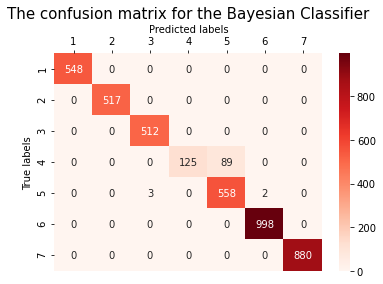

In [143]:
confusion_bayes = confusion_matrix(y_test, y_pred_bayes) # get the confusion matrix

fig, ax = plt.subplots()
ax = sns.heatmap(confusion_bayes, annot=True, fmt='g', xticklabels=lab, yticklabels=lab, cmap="Reds")
ax.set_title("The confusion matrix for the Bayesian Classifier", fontsize = 15)
ax.set_xlabel('Predicted labels')
ax.set_ylabel("True labels")
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.show()

In [144]:
accuracy_bayes = accuracy_score(y_test,y_pred_bayes)
print(f"The accuracy of the k-Nearest Neighbors Classifier is: {accuracy_bayes:.4f}.")
# confusion_bayes.diagonal().sum() / confusion_bayes.sum()

The accuracy of the k-Nearest Neighbors Classifier is: 0.9778.


Having fitted all the four classifiers we are ready to compare them and see which one or ones are the best for our problem.

The four confusion matrices are displayed below: 


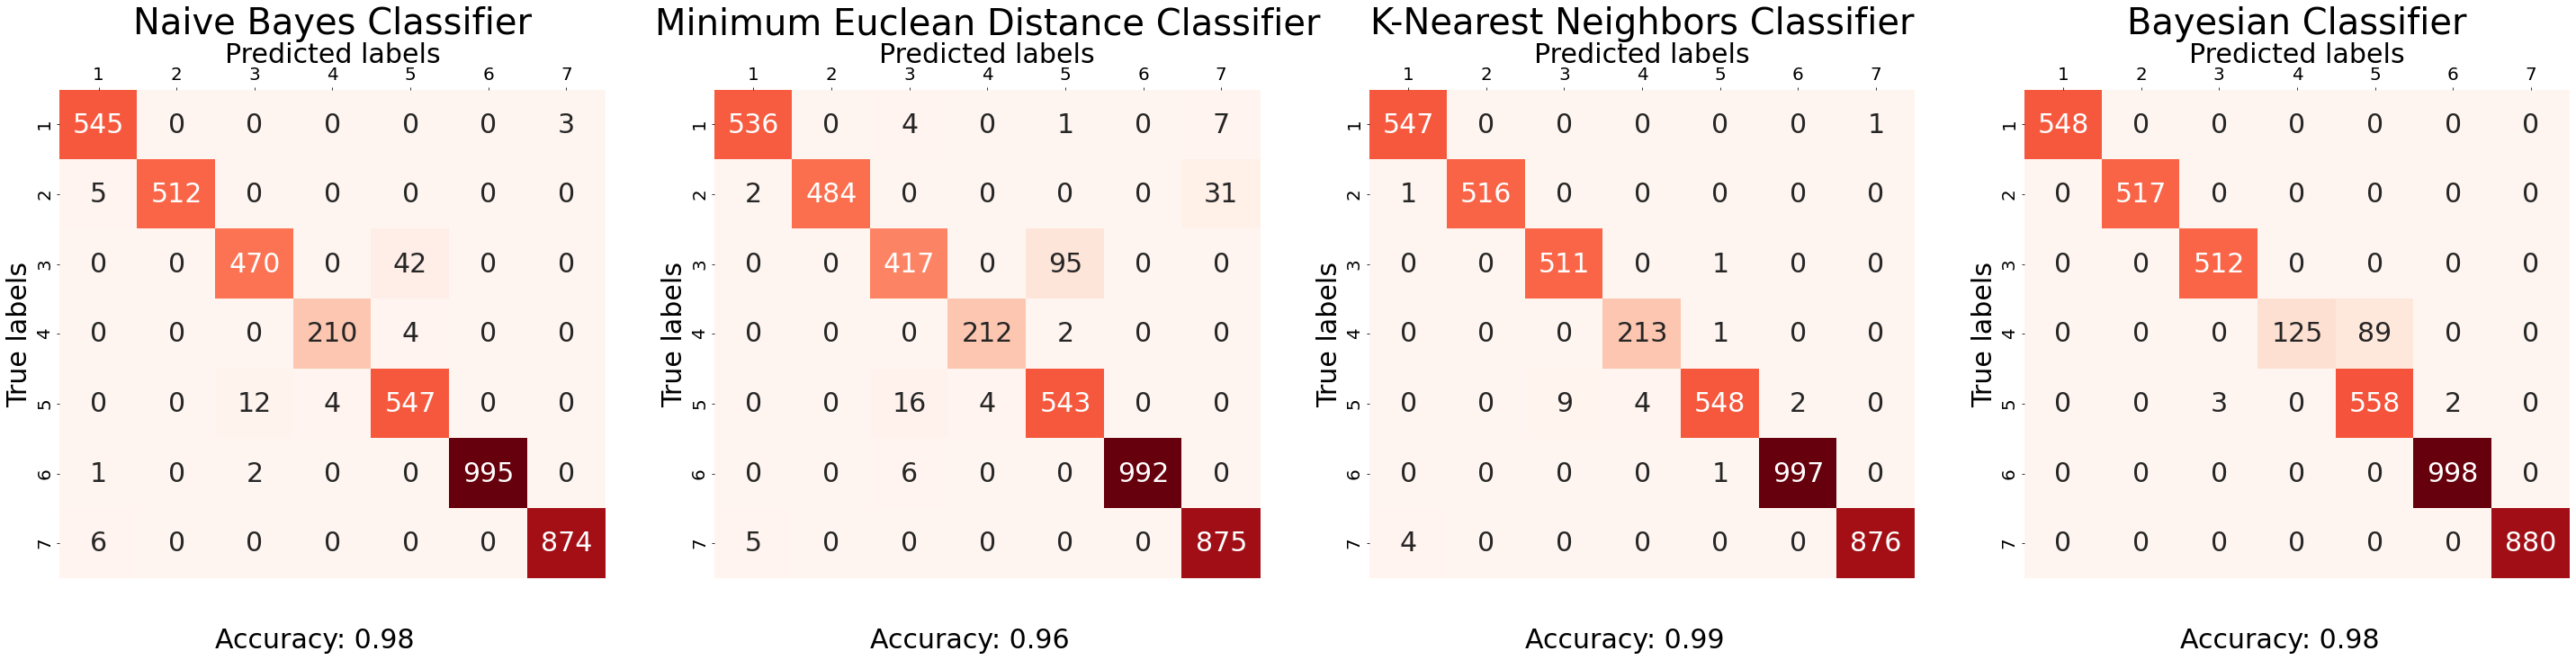

In [145]:
# keep the four confusion matrices in a dictionary
confusions = {'Naive Bayes Classifier': [accuracy_naive, confusion_naive],
             'Minimum Euclean Distance Classifier': [accuracy_mindist,  confusion_mindist],
             'K-Nearest Neighbors Classifier': [accuracy_knn, confusion_knn],
             'Bayesian Classifier': [accuracy_bayes, confusion_bayes]}

print("The four confusion matrices are displayed below: ")

# plot all four confusion matrices the one beside the other
fig = plt.figure(figsize=(50,10))
i = 1
for method, scores in confusions.items():
    ax = fig.add_subplot(1,4,i)
    ax = sns.heatmap(scores[1], annot=True, annot_kws={'size': 30}, fmt='g', cbar=False, cmap="Reds", 
                                                                 xticklabels=lab, yticklabels=lab)
    ax.set_title(f"{method}", fontsize = 40)
    ax.set_xlabel('Predicted labels', fontsize=30)
    ax.set_ylabel("True labels", fontsize=30)
    ax.set_xticklabels(labels = lab, fontsize=20)
    ax.set_yticklabels(labels = lab, fontsize=20)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.text(x = 2, y = 8, s = f"Accuracy: {scores[0]:.2f}", fontsize=30)
    i+=1
plt.show()

We conclude the following:
* the Minimum Distance Classifier is the worst out of the four, with very lower accuracy and a confusion matrix that does not seem very good. It mixes up the 1st and the 5th class, mispredicting 121 pixels from label 1 to label 5 and 125 pixels from label 5 to label 1. Furthermore, it mixes up the labels 3 and 7, misclassifying 147 pixels with lael 3 to label 7 and 126 pixels with label 7 to label 3.

* We see that the Naive Bayes Classifier predict very well the labels, although it confuses a little bit the 3rd with the 5th class, as it misclassifies 42 pixels with label 3 to label 5 and 12 pixels with label 5 to label 3. Beyond that the naive bayes does an excellent job. 

* The Bayesian Classifier, which has the same accuracy approximately with the Naive Bayes, does a very good job, with the only problem being that it mixes up the label 4 with the label 5, as it sends 89 pixels of label 4 to classify to label 5. This error is only for the class 4, and does not mixes up the fifth, because we use the Gaussian method and the class 5 has a lot more pixels than the class 4, so a large proportion of the gaussian function of class 4 is inscuded in the function of class 5.

* Leaving the best for the end, the KNN classifier does an extremely good job at classifying correctly the labels of the pixels. 9 labels 5 that are classified to 3 and 4 labels 5 that are classified to 4 are not significant mistakes at all. Also,the accuracy is even higher than the Bayes and the Naive Bayes. This is very logical if we thinkg that we have a lot of pixels with label 0, meaning unknown label. So, the classes are well separated with each other, and taking the neighbors for a pixel we will have a very large probability to be in the same class. So, if we use 1-NN we expect that the classifier will do even better job, but we will overfit the data. If after that take the labels that right now we do not know, we may have worst results, than the 10-NN. 

## Part 3

#### Combination of Spectral Unmixing and Classification

In the part 1 we do spectral unmixing as a regression task. So the results are the different endmembers. Thus this task is in essence a classification task, where we design each endmember separatively. In the part 2 we classify the pixels in the 7 labels. Hence, the two approaches do the same classification job. In the first part we obtain the thetas, that are in essence the probabilities that a pixel belongs to the classes, and we assign the pixel to the class with the higher probability. In the second part we do straightforward this classification, so the two results must agree with each other. 